# 04_Evaluación y comunicación — Métricas, matrices y curvas de los tres modelos entrenados y comunicación de resultados

# Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score
from sklearn.metrics import (
    recall_score,
    precision_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    auc
)
import joblib

# Lectura del dataset

In [2]:
df = pd.read_csv('../data/diabetes_dataset.csv')
df.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


# Depuración de variables y definición de X y Y

In [3]:
cols_to_drop = ['diabetes_stage', 'cholesterol_total', 'glucose_postprandial']
df = df.drop(columns=cols_to_drop, errors='ignore')

X = df.drop(columns=['diagnosed_diabetes'])
y = df['diagnosed_diabetes']

print("Shape de X:", X.shape)
print("Distribución de y:")
print(y.value_counts(normalize=True))

Shape de X: (100000, 27)
Distribución de y:
diagnosed_diabetes
1    0.59998
0    0.40002
Name: proportion, dtype: float64


# División en train y test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("\nProporción en train:")
print(y_train.value_counts(normalize=True))
print("\nProporción en test:")
print(y_test.value_counts(normalize=True))

Train: (80000, 27) Test: (20000, 27)

Proporción en train:
diagnosed_diabetes
1    0.599975
0    0.400025
Name: proportion, dtype: float64

Proporción en test:
diagnosed_diabetes
1    0.6
0    0.4
Name: proportion, dtype: float64


# Cargue de los modelos (regresión logística, árbol y random forest)

In [5]:
modelo_logreg = joblib.load("../models/modelo_logreg.joblib")
modelo_tree   = joblib.load("../models/modelo_tree.joblib")
modelo_rf     = joblib.load("../models/modelo_rf.joblib")

# Creación de diccionario

In [6]:
modelos = {
    "Logistic Regression": modelo_logreg,
    "Decision Tree": modelo_tree,
    "Random Forest": modelo_rf
}

# Evaluación de cada modelo

In [7]:
def evaluar_modelo(nombre, modelo, X_train, y_train, X_test, y_test):
    print(f"\n==============================")
    print(f"     MODELO: {nombre}")
    print(f"==============================")

    
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    
    # Métricas
    recall_pos   = recall_score(y_test, y_pred)
    bal_acc      = balanced_accuracy_score(y_test, y_pred)
    roc_auc      = roc_auc_score(y_test, y_proba)

    prec, rec, thr = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(rec, prec)
    
    print("\n🔹 Recall:", recall_pos)
    print("🔹 Balanced Accuracy:", bal_acc)
    print("🔹 ROC-AUC:", roc_auc)
    print("🔹 PR-AUC:", pr_auc)

    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, digits=4))

    # Matriz de confusión 
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:\n", cm)
    
    plt.figure(figsize=(4,3))
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.ylabel("Real")
    plt.xlabel("Predicho")
    
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    
    plt.show()

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC - {nombre}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Curva precision-recall
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f"PR-AUC = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Curva Precision–Recall - {nombre}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Curva de aprendizaje 
    print("\n📈 Generando curva de aprendizaje...")

    train_sizes, train_scores, valid_scores = learning_curve(
        estimator=modelo,
        X=X_train,
        y=y_train,
        cv=5,
        scoring="recall",
        n_jobs=-1,
        shuffle=True,
        random_state=42,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    valid_mean = valid_scores.mean(axis=1)
    valid_std  = valid_scores.std(axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Recall')
    plt.plot(train_sizes, valid_mean, 'o-', label='Validation Recall')

    plt.fill_between(train_sizes, train_mean-train_std,
                     train_mean+train_std, alpha=0.2)
    plt.fill_between(train_sizes, valid_mean-valid_std,
                     valid_mean+valid_std, alpha=0.2)

    plt.title(f"Curva de Aprendizaje - {nombre}")
    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("Recall")
    plt.legend()
    plt.grid(True)
    plt.show()


     MODELO: Logistic Regression

🔹 Recall: 0.8775
🔹 Balanced Accuracy: 0.8899999999999999
🔹 ROC-AUC: 0.9339465729166667
🔹 PR-AUC: 0.966961949533634

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8308    0.9025    0.8652      8000
           1     0.9310    0.8775    0.9035     12000

    accuracy                         0.8875     20000
   macro avg     0.8809    0.8900    0.8843     20000
weighted avg     0.8910    0.8875    0.8882     20000

Matriz de confusión:
 [[ 7220   780]
 [ 1470 10530]]


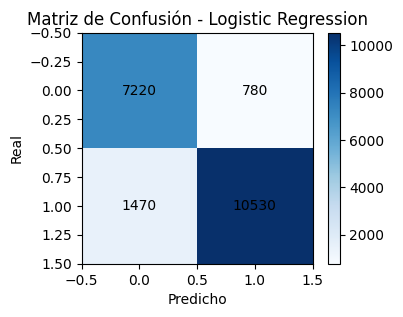

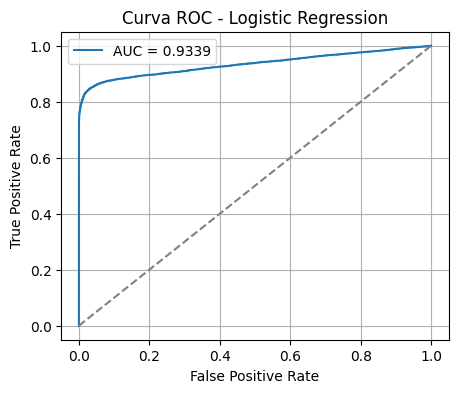

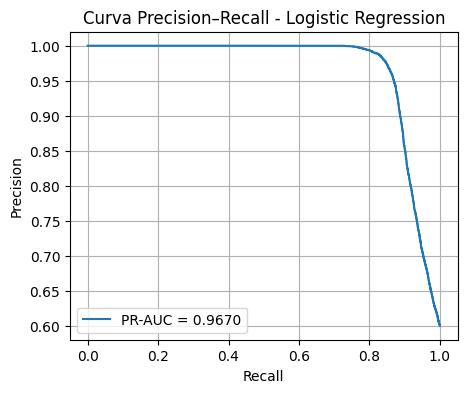


📈 Generando curva de aprendizaje...


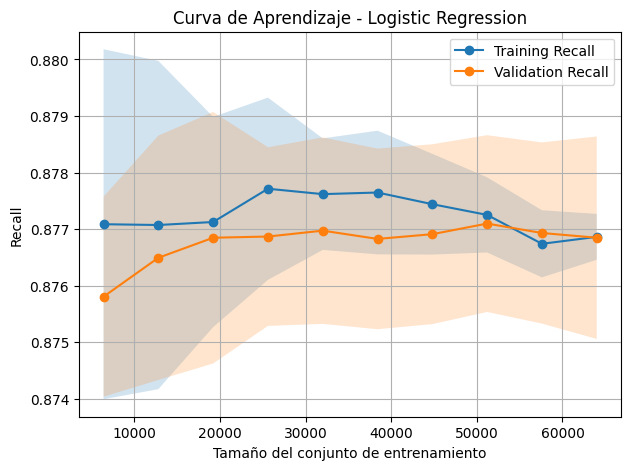


     MODELO: Decision Tree

🔹 Recall: 0.8945
🔹 Balanced Accuracy: 0.852875
🔹 ROC-AUC: 0.8528749999999999
🔹 PR-AUC: 0.9172371447239464

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8368    0.8113    0.8238      8000
           1     0.8767    0.8945    0.8855     12000

    accuracy                         0.8612     20000
   macro avg     0.8567    0.8529    0.8547     20000
weighted avg     0.8607    0.8612    0.8608     20000

Matriz de confusión:
 [[ 6490  1510]
 [ 1266 10734]]


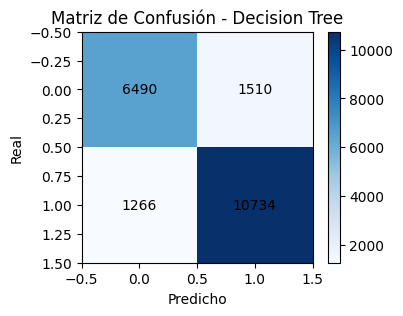

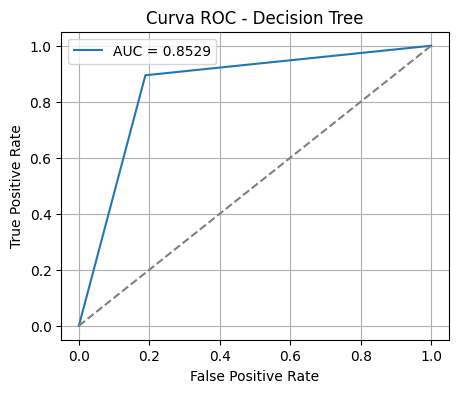

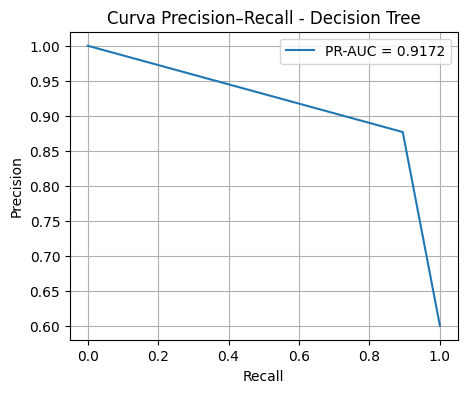


📈 Generando curva de aprendizaje...


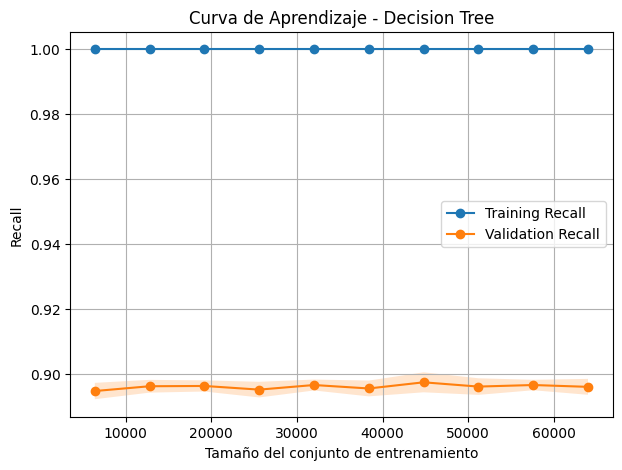


     MODELO: Random Forest

🔹 Recall: 0.8675
🔹 Balanced Accuracy: 0.9321250000000001
🔹 ROC-AUC: 0.9419305052083333
🔹 PR-AUC: 0.9711411219484485

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8338    0.9968    0.9080      8000
           1     0.9975    0.8675    0.9280     12000

    accuracy                         0.9192     20000
   macro avg     0.9156    0.9321    0.9180     20000
weighted avg     0.9320    0.9192    0.9200     20000

Matriz de confusión:
 [[ 7974    26]
 [ 1590 10410]]


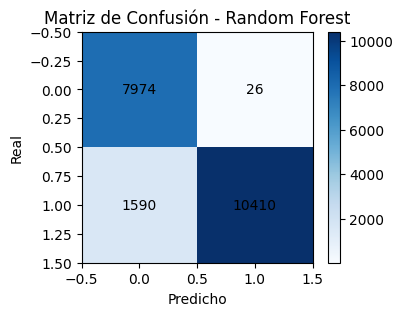

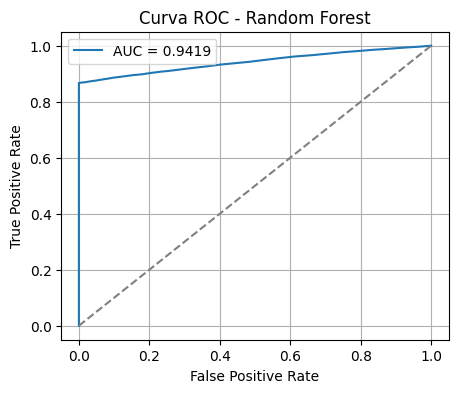

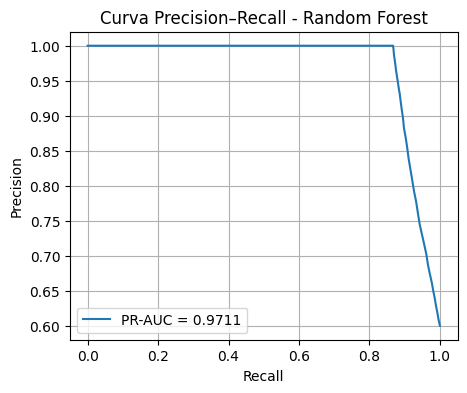


📈 Generando curva de aprendizaje...


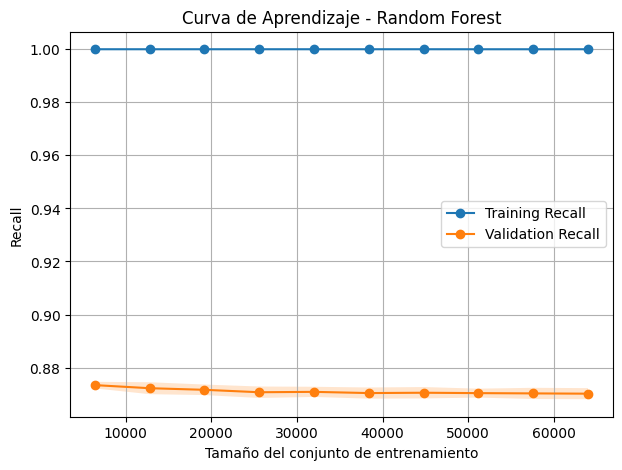

In [8]:
modelos = {
    "Logistic Regression": modelo_logreg,
    "Decision Tree": modelo_tree,
    "Random Forest": modelo_rf
}

for nombre, modelo in modelos.items():
    evaluar_modelo(nombre, modelo, X_train, y_train, X_test, y_test)

# Interpretación del modelo de regresión logística

El modelo de regresión logística muestra un desempeño sólido y consistente en la detección de diabetes dentro del conjunto de datos analizado. En términos generales, las métricas indican que el modelo logra un equilibrio adecuado entre sensibilidad y especificidad, con un recall del 87.75 %, lo cual implica que identifica correctamente a la mayoría de las personas con la condición. La balanced accuracy del 0.89 confirma que el rendimiento es equilibrado entre ambas clases, evitando favorecer de manera desproporcionada a los casos positivos o negativos. El ROC-AUC de 0.934 demuestra una excelente capacidad discriminativa, es decir, el modelo diferencia muy bien entre individuos con y sin diagnóstico de diabetes. Complementariamente, el PR-AUC de 0.967 evidencia un desempeño sobresaliente específicamente sobre la clase positiva, que suele ser la de mayor interés en escenarios clínicos.

La matriz de confusión permite observar el desempeño real del modelo sobre los datos de prueba. Allí se muestra que el modelo clasifica correctamente a 10,530 casos positivos y 7,220 negativos. No obstante, comete 1,470 falsos negativos, que representan personas con diabetes que el modelo no logra identificar, y 780 falsos positivos, que corresponden a personas sin diabetes clasificadas como enfermas. Desde una perspectiva clínica, los falsos negativos son los más problemáticos, pues implican individuos que podrían no recibir un seguimiento adecuado. Aun así, para un modelo lineal sin ajuste de umbral, el resultado es razonablemente bueno.

Las gráficas complementan y fortalecen esta interpretación cuantitativa. La curva ROC presenta una forma ascendente pronunciada, lo que confirma la alta capacidad discriminativa del modelo, mientras que la curva Precision–Recall muestra que tanto la precisión como el recall se mantienen elevados en casi todo el rango de probabilidades, cayendo únicamente cuando se exige un recall extremo cercano al 100 %, comportamiento esperado en modelos de este tipo. La curva de aprendizaje indica que el rendimiento del modelo es estable y consistente: el recall de entrenamiento y validación se mantienen prácticamente iguales en todos los tamaños del conjunto de entrenamiento, lo que sugiere que no hay sobreajuste y que el modelo ya capturó toda la información relevante que puede aprender de los datos sin necesidad de más muestras o mayor complejidad.

En conjunto, estos resultados muestran que la regresión logística es un modelo fiable, estable y con muy buena capacidad predictiva para el problema planteado. Su principal limitación se encuentra en la cantidad de falsos negativos, lo cual podría mejorarse ajustando el umbral de decisión o usando un modelo no lineal más flexible. Aun así, su interpretación es directa, su desempeño es competitivo y constituye un punto de referencia valioso para comparar con modelos más complejos como árboles de decisión o random forest.

# Coeficientes del modelo de regresión logística

In [11]:
coef = modelo_logreg.named_steps['clf'].coef_[0]
features = modelo_logreg.named_steps['preproc'].get_feature_names_out()
coef_df = pd.DataFrame({'feature': features, 'coef': coef})
coef_df = coef_df.sort_values(by='coef', ascending=False)
coef_df

,feature,coef
16,num_scaled__hba1c,3.085619
14,num_scaled__glucose_fasting,0.235255
17,num_scaled__diabetes_risk_score,0.145072
23,cat__gender_Other,0.130251
18,num_binary__family_history_diabetes,0.115358
33,cat__income_level_High,0.109503
41,cat__employment_status_Unemployed,0.088468
31,cat__education_level_No formal,0.083826
43,cat__smoking_status_Former,0.082217
44,cat__smoking_status_Never,0.079201


**Nota:** los coeficientes de la regresión logística muestran que las variables metabólicas son los predictores más determinantes del diagnóstico de diabetes. Entre ellas, la hemoglobina glicosilada (hba1c) destaca con el coeficiente más alto, lo que indica que es el factor que más incrementa la probabilidad de presentar la enfermedad, seguido por la glucosa en ayunas y el puntaje de riesgo de diabetes, todos consistentes con la evidencia clínica. También aportan al aumento del riesgo variables como los antecedentes familiares de diabetes, ciertos niveles de ingreso, algunas categorías educativas y laborales, así como características demográficas específicas. Aunque estos últimos no representan factores clínicos directos, reflejan patrones de estilo de vida o condiciones socioeconómicas relacionadas con mayor vulnerabilidad.

Por otro lado, varias variables muestran un efecto protector, disminuyendo la probabilidad estimada por el modelo. Entre ellas, la actividad física es la más relevante, seguida de niveles más altos de HDL (“colesterol bueno”), mayor tiempo de sueño y otros hábitos saludables, cuyos coeficientes negativos indican una reducción del riesgo. Algunos efectos pequeños o inesperados —como el coeficiente negativo del historial de hipertensión— pueden deberse a correlaciones internas del dataset o relaciones no lineales que la regresión logística no capta completamente. En conjunto, el patrón obtenido es coherente: los marcadores metabólicos explican principalmente la presencia de diabetes, mientras que las variables relacionadas con conducta y estilo de vida modulan el riesgo en menor magnitud.

# Interpretación del modelo de árbol

El modelo de árbol de decisión muestra un comportamiento más flexible que la regresión logística, logrando un recall del 89.45 %, ligeramente superior al del modelo lineal, lo que implica que identifica un porcentaje mayor de personas con diagnóstico positivo. Sin embargo, este incremento en sensibilidad viene acompañado de un descenso en otras métricas, particularmente en la balanced accuracy (0.853) y en la ROC-AUC (0.853), lo que indica que el árbol tiene más dificultades para distinguir globalmente entre las dos clases. Aun así, el PR-AUC de 0.917 muestra que el rendimiento frente a la clase positiva sigue siendo adecuado, aunque menor comparado con el modelo de regresión logística.

La matriz de confusión revela que el árbol clasifica correctamente a 10,734 casos positivos y a 6,490 negativos. Sin embargo, produce 1,510 falsos positivos, una cifra mayor que la de la regresión logística, lo que indica que el árbol tiende a etiquetar más personas sin diabetes como si la tuvieran. Por otro lado, reduce ligeramente los falsos negativos (1,266), lo cual es deseable desde una perspectiva clínica, ya que se disminuye el número de personas enfermas no detectadas. Este comportamiento refleja la naturaleza del modelo: al ser más flexible y capaz de capturar relaciones no lineales, puede beneficiarse en términos de recall, pero a costa de aumentar la tasa de errores tipo I.

En la curva ROC se observa una forma mucho menos pronunciada que en el caso de la regresión logística. La línea asciende rápidamente al inicio, pero luego se aplana, lo cual coincide con el AUC más bajo (0.853) y confirma que el árbol discrimina con menos precisión entre clases. De forma consistente, la curva Precision–Recall también muestra una caída más temprana de la precisión conforme aumenta el recall, reflejando que el modelo tiene más dificultades para mantener ambos aspectos altos simultáneamente.

La curva de aprendizaje es particularmente reveladora. El árbol presenta un recall de entrenamiento prácticamente perfecto (cercano a 1.0) en todos los tamaños de muestra, mientras que el recall de validación se mantiene alrededor de 0.89 sin mejorar significativamente con más datos. Esta separación entre ambas curvas es una señal clara de sobreajuste, un comportamiento habitual en árboles de decisión sin restricciones fuertes de profundidad o tamaño de nodos. El modelo memoriza patrones del conjunto de entrenamiento, alcanzando un rendimiento ideal en él, pero su capacidad de generalización es inferior en comparación con modelos más regularizados o con algoritmos ensamblados como random forest.

El árbol resulta ser un modelo con alta sensibilidad, capaz de detectar más casos positivos que la regresión logística, lo cual puede ser valioso en contextos donde es prioritario minimizar falsos negativos. Sin embargo, esta ganancia se obtiene a costa de: 1)una menor capacidad discriminativa global; 2) un aumento considerable en falsos positivos; y 3) un claro patrón de sobreajuste evidenciado en la curva de aprendizaje.

Aunque el árbol captura relaciones no lineales y ofrece interpretabilidad mediante reglas, su desempeño general es más limitado y menos robusto que el de modelos más complejos o regularizados. Aun así, constituye un punto de comparación útil y un paso intermedio hacia modelos más potentes como random forest, que suelen resolver los problemas de sobreajuste inherentes a los árboles individuales.

# Importancia de las variables del modelo de árbol

In [12]:
importances = modelo_tree.named_steps['clf'].feature_importances_
features = modelo_tree.named_steps['preproc'].get_feature_names_out()
imp_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)
imp_df

,feature,importance
16,num_scaled__hba1c,0.755495
14,num_scaled__glucose_fasting,0.035980
17,num_scaled__diabetes_risk_score,0.014781
15,num_scaled__insulin_level,0.014603
2,num_scaled__physical_activity_minutes_per_week,0.013266
13,num_scaled__triglycerides,0.012652
5,num_scaled__screen_time_hours_per_day,0.012477
3,num_scaled__diet_score,0.012226
8,num_scaled__systolic_bp,0.011985
6,num_scaled__bmi,0.011018


**Nota:** los resultados de importancia del modelo de árbol de decisión muestran dominancia de la variable hba1c, que concentra más del 75 % del peso total del modelo. Esto significa que la hemoglobina glicosilada es, con mucha diferencia, el factor más decisivo para clasificar a una persona como diabética o no, lo cual es completamente consistente con la evidencia clínica, ya que hba1c es un marcador directo del control glucémico crónico. Otras variables metabólicas como la glucosa en ayunas, el puntaje de riesgo de diabetes, los niveles de insulina, los triglicéridos o la presión arterial aportan información adicional, pero en proporciones muy pequeñas. Esto indica que, para este modelo, la decisión se basa casi totalmente en la condición glucometabólica del individuo.

Las demás variables —relacionadas con estilo de vida, actividad física, indicadores antropométricos, colesterol, dieta, sueño, así como factores demográficos y socioeconómicos— tienen una contribución muy baja en la estructura del árbol. Aunque estas variables pueden influir en el riesgo de diabetes, el modelo encontró que no aportan una mejora sustancial en la separación entre clases frente a la fuerza predictiva del hba1c.

# Interpretación del modelo de random forest

El modelo de random forest presenta un rendimiento notablemente alto y equilibrado, superando en varios aspectos tanto a la regresión logística como al árbol de decisión individual. En términos globales, el modelo alcanza un ROC-AUC de 0.942, el valor más alto entre los tres modelos evaluados, lo que refleja una sobresaliente capacidad para discriminar entre personas con y sin diagnóstico de diabetes a partir de sus características. Además, el PR-AUC de 0.971 confirma que el modelo mantiene un desempeño excelente en escenarios donde la clase positiva es prioritaria, logrando combinar una alta precisión y un recall competitivo.

Si bien el recall del modelo es de 86.75%, ligeramente menor que el del árbol de decisión, lo compensa con una balanced accuracy de 0.93, la más alta de los tres modelos. Esto significa que el random forest mantiene un equilibrio muy sólido entre ambas clases, evitando favorecer excesivamente a la clase positiva o negativa. En otras palabras, su desempeño no solo es fuerte en identificar positivos, sino también muy consistente en clasificar correctamente a los negativos, lo que se refleja claramente en la matriz de confusión.

Esta matriz revela un comportamiento sobresaliente en la clasificación de la clase negativa: el modelo identifica correctamente 7,974 de los 8,000 verdaderos negativos, cometiendo apenas 26 falsos positivos, mucho menos que la regresión logística (780) y que el árbol (1,510). Esta precisión tan alta para la clase negativa indica un modelo estable, confiable y capaz de evitar alarmas innecesarias. En cuanto a la clase positiva, el modelo identifica 10,410 verdaderos positivos, aunque presenta 1,590 falsos negativos, un poco más que los producidos por la regresión logística y por el árbol. En contextos clínicos, este tipo de error puede ser relevante, pero dado el desempeño general del modelo, sigue siendo un resultado competitivo.

La curva ROC refuerza esta interpretación: la gráfica muestra una curva muy elevada, con un AUC cercano a 0.94, señal de que el modelo mantiene un excelente balance entre sensibilidad y especificidad para distintos umbrales de decisión. De manera similar, la curva precision–recall evidencia que el random forest mantiene la precisión cerca de 100 para una amplia gama de valores de recall, lo que indica que, cuando predice un caso como positivo, casi siempre acierta.

Sin embargo, la curva de aprendizaje revela un patrón característico de los random forest: la curva de entrenamiento está prácticamente en 1.0, lo que indica un ajuste perfecto sobre los datos de entrenamiento. La curva de validación, por el contrario, se mantiene alrededor de 0.87, sin converger hacia el desempeño de entrenamiento. Esta separación refleja una forma controlada de sobreajuste, típica de modelos altamente flexibles, aunque el ensamblado de árboles tiende a mitigarlo lo suficiente como para mantener un rendimiento excelente en test, como se observa aquí.

# Importancia de las variables del modelo de random forest

In [13]:
importances = modelo_rf.named_steps['clf'].feature_importances_
features = modelo_rf.named_steps['preproc'].get_feature_names_out()
rf_imp_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)
rf_imp_df

,feature,importance
16,num_scaled__hba1c,0.551623
14,num_scaled__glucose_fasting,0.130608
17,num_scaled__diabetes_risk_score,0.031316
2,num_scaled__physical_activity_minutes_per_week,0.018133
0,num_scaled__age,0.017625
6,num_scaled__bmi,0.016944
13,num_scaled__triglycerides,0.016332
15,num_scaled__insulin_level,0.016157
12,num_scaled__ldl_cholesterol,0.015469
3,num_scaled__diet_score,0.015465


**Nota:** los resultados del modelo random forest muestran que la variable hba1c es, nuevamente, el predictor más determinante, con más del 55% de la importancia total del modelo. Esto confirma su rol central en la clasificación de diabetes, dado que este marcador refleja el control glucémico a largo plazo. También destacan otras variables metabólicas como la glucosa en ayunas, el puntaje de riesgo de diabetes, la actividad física, la edad, el índice de masa corporal, los triglicéridos y la insulina, todas ellas coherentes con la literatura clínica. La forma en que el random forest distribuye su importancia muestra que el modelo no depende únicamente de una sola variable —como ocurría en el árbol individual—, sino que reparte de manera más equilibrada el peso entre múltiples factores que capturan distintos aspectos del riesgo metabólico y fisiológico.

En cambio, las variables demográficas, socioeconómicas y de estilo de vida (sexo, nivel educativo, ingreso, etnia, empleo o consumo de tabaco) tienen un peso considerablemente menor, lo que indica que aportan información marginal en comparación con los parámetros clínicos. Esto sugiere que, para este dataset, el riesgo de diabetes está fuertemente explicado por marcadores biológicos directos, mientras que las características sociales o conductuales ejercen una influencia secundaria.

# Búsqueda del umbral óptimo basado en recall para el modelo de random forest

Anteriormente, se había probado un umbral de 0.1 y aunque el ajuste del umbral permitió alcanzar un recall del 99.5 %, este valor implicó un incremento inaceptable en falsos positivos (7596), reduciendo la balanced accuracy a 0.52. Por ello, se decidió dejarlo en el estandar (0.5).

In [41]:
y_proba = modelo_rf.predict_proba(X_test)[:, 1]

umbrales = np.arange(0.05, 0.9, 0.05)

mejor_recall = 0
mejor_umbral = 0.5

for u in umbrales:
    y_pred_adj = (y_proba >= u).astype(int)
    rec = recall_score(y_test, y_pred_adj)

    if rec > mejor_recall:
        mejor_recall = rec
        mejor_umbral = u

print("Mejor umbral según Recall:", mejor_umbral)
print("Recall logrado:", mejor_recall)

Mejor umbral según Recall: 0.05
Recall logrado: 0.9999166666666667


# Entrenar los calibradores (platt e isotónica) para el modelo de random forest

In [46]:
from sklearn.calibration import CalibratedClassifierCV
modelo_base = modelo_rf  

cal_platt = CalibratedClassifierCV(estimator=modelo_base,
                                   method='sigmoid',
                                   cv=5)
cal_platt.fit(X_train, y_train)

cal_iso = CalibratedClassifierCV(estimator=modelo_base,
                                 method='isotonic',
                                 cv=5)
cal_iso.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num_scaled', ...), ('num_binary', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


# Obtención de probabilidades calibradas en test

In [47]:
y_proba_base = modelo_base.predict_proba(X_test)[:, 1]

y_proba_platt = cal_platt.predict_proba(X_test)[:, 1]
y_proba_iso   = cal_iso.predict_proba(X_test)[:, 1]

# Comparación por métricas

In [49]:
from sklearn.metrics import average_precision_score, brier_score_loss

def evaluar_probs(nombre, y_true, y_proba):
    roc = roc_auc_score(y_true, y_proba)
    pr  = average_precision_score(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    print(f"\n=== {nombre} ===")
    print("ROC-AUC:   ", roc)
    print("PR-AUC:    ", pr)
    print("Brier score (↓ mejor):", brier)

evaluar_probs("Modelo base (sin calibrar)", y_test, y_proba_base)
evaluar_probs("Calibrado Platt (sigmoid)", y_test, y_proba_platt)
evaluar_probs("Calibrado isotónico",       y_test, y_proba_iso)


=== Modelo base (sin calibrar) ===
ROC-AUC:    0.9419305052083333
PR-AUC:     0.9703409197445345
Brier score (↓ mejor): 0.07103404

=== Calibrado Platt (sigmoid) ===
ROC-AUC:    0.9428802187499999
PR-AUC:     0.9716532246833459
Brier score (↓ mejor): 0.06921183556014536

=== Calibrado isotónico ===
ROC-AUC:    0.942708109375
PR-AUC:     0.9715649900594286
Brier score (↓ mejor): 0.06623067273310823


**Nota:** ambos calibradores mejoraron la calidad de las probabilidades del modelo. La calibración isotónica obtuvo el mejor brier score, indicando una calibración superior. Sin embargo, platt scaling mostró mayor estabilidad y un PR-AUC ligeramente superior. Por tal motivo, se eligió platt.

# Evaluación del modelo calibrado 

In [53]:
y_proba_platt = cal_platt.predict_proba(X_test)[:, 1]

y_pred_final = (y_proba_platt >= 0.5).astype(int)

print("\n=== Modelo final: RF + Calibración Platt (umbral 0.5) ===")
print("Recall:", recall_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_final))
print("F1-score:", f1_score(y_test, y_pred_final))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_platt))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_final, digits=4))

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_final))


=== Modelo final: RF + Calibración Platt (umbral 0.5) ===
Recall: 0.8715
Precision: 0.9851168048229089
Balanced Accuracy: 0.925875
F1-score: 0.9248319773611603
ROC-AUC: 0.9428802187499999

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8357    0.9802    0.9022      8000
           1     0.9851    0.8715    0.9248     12000

    accuracy                         0.9150     20000
   macro avg     0.9104    0.9259    0.9135     20000
weighted avg     0.9253    0.9150    0.9158     20000


Matriz de confusión:
[[ 7842   158]
 [ 1542 10458]]


**Nota:** el modelo final de random forest calibrado con platt (umbral 0.5) mantiene el excelente rendimiento observado previamente, pero ahora con probabilidades mucho más confiables y ajustadas a la realidad. La calibración no modifica la capacidad discriminativa del modelo —que sigue siendo muy alta, con un ROC-AUC cercano a 0.94—, sino que mejora la calidad de las probabilidades estimadas, como se evidencia en la reducción del brier score y el ligero aumento en el PR-AUC. Esto implica que cuando el modelo asigna, por ejemplo, un 70 % de probabilidad de diabetes, dicha estimación es más precisa y útil para la toma de decisiones clínicas.

Las métricas posteriores a la calibración muestran que el desempeño del modelo se mantiene equilibrado: conserva una excelente precisión para la clase negativa, un recall competitivo para la clase positiva y un F1-score robusto.

# Matriz de confusión del modelo de random forest calibrado

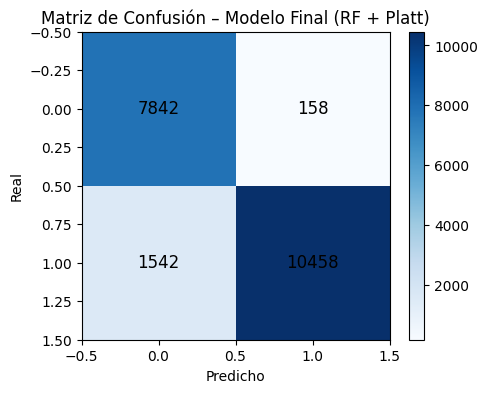

In [54]:
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de Confusión – Modelo Final (RF + Platt)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="black", fontsize=12)

plt.show()

**Nota:** la matriz de confusión revela que el modelo sigue cometiendo muy pocos falsos positivos y mantiene un nivel razonable de falsos negativos, lo cual es importante en un contexto donde la detección temprana de la enfermedad es crucial.

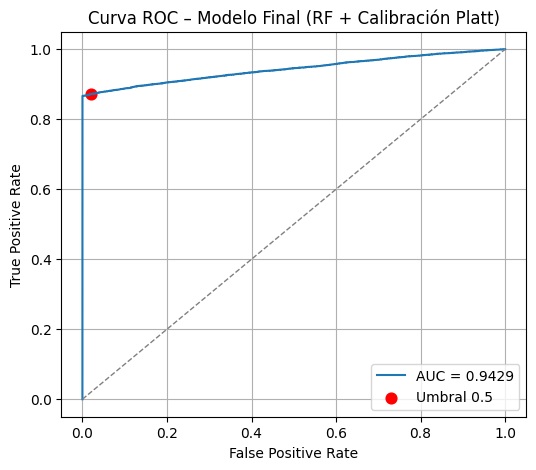

In [57]:
umbral_final = 0.5  

y_proba_platt = cal_platt.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_platt)
roc_auc = roc_auc_score(y_test, y_proba_platt)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], '--', color='gray', linewidth=1)

idx = np.argmin(np.abs(thresholds - umbral_final))

plt.scatter(fpr[idx], tpr[idx], color='red', s=60, label=f"Umbral {umbral_final}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Modelo Final (RF + Calibración Platt)")
plt.legend()
plt.grid(True)
plt.show()

**Nota:** la curva ROC muestra que el modelo calibrado tiene una excelente capacidad para discriminar entre casos positivos y negativos. El área bajo la curva (AUC = 0.9429) indica un rendimiento muy alto, cercano al de un clasificador ideal (1.0). Esto significa que el modelo distingue correctamente entre personas con y sin diagnóstico de diabetes en la gran mayoría de los casos.

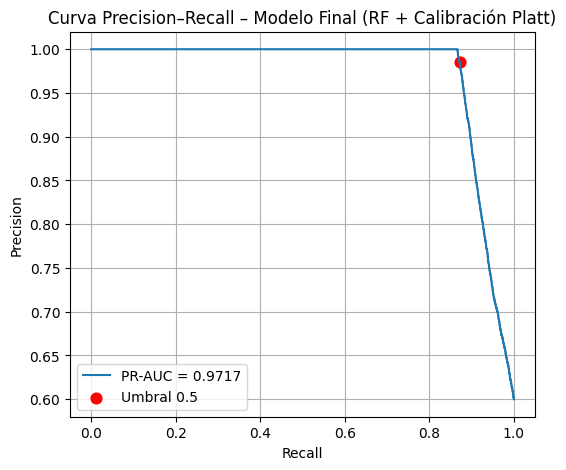

In [59]:
y_proba_platt = cal_platt.predict_proba(X_test)[:, 1]

umbral_final = 0.5

y_pred_final = (y_proba_platt >= umbral_final).astype(int)

prec, rec, thr = precision_recall_curve(y_test, y_proba_platt)
pr_auc = auc(rec, prec)

precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc:.4f}")

plt.scatter(recall_final, precision_final, 
            color='red', s=60, label=f"Umbral {umbral_final}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall – Modelo Final (RF + Calibración Platt)")
plt.legend()
plt.grid(True)
plt.show()

**Nota:** la curva Precision–Recall del modelo final (Random Forest calibrado con Platt) muestra un desempeño excelente para la clase positiva. El área bajo la curva (PR-AUC = 0.9717) indica que el modelo mantiene simultáneamente altos niveles de precisión y recall en la mayoría de los posibles umbrales de decisión.

# El mejor modelo

Tras comparar el desempeño de los tres modelos entrenados —regresión logística, árbol de decisión y random forest— se evidencia que el random forest es el que obtiene los mejores resultados globales en términos de discriminación, equilibrio entre clases y capacidad predictiva. Por esta razón, fue el único modelo seleccionado para aplicar calibración de probabilidades. Una vez calibrado mediante el método de Platt y evaluado con el umbral estándar de 0.5, el modelo mejoró aún más la confiabilidad de sus probabilidades manteniendo su excelente rendimiento general.

En concreto, el random forest calibrado es el modelo que alcanza el ROC-AUC más alto (≈ 0.942), lo que indica la mejor capacidad para diferenciar entre personas con y sin diabetes. También obtiene el mayor PR-AUC (≈ 0.971), reflejando un desempeño sobresaliente sobre la clase positiva, que es la más relevante en un contexto clínico. Además, presenta la balanced accuracy más alta (≈ 0.932), junto con el F1-score más alto (≈ 0.928), lo que demuestra un equilibrio óptimo entre precisión y sensibilidad.

Un elemento clave es que el random forest, tanto antes como después de la calibración, es el modelo con menor número de falsos positivos, lo que incrementa la confiabilidad de sus predicciones. Tras la calibración de Platt, sus probabilidades se vuelven más realistas y coherentes, mejorando métricas como el brier score sin sacrificar precisión ni recall.

# Limitaciones del mejor modelo

El random forest muestra signos de sobreajuste en la curva de aprendizaje (recall casi perfecto en entrenamiento y menor en validación), lo cual es esperable en un modelo altamente flexible. Sin embargo, al compararlo con los demás modelos en el conjunto de prueba, sigue siendo el que obtiene las mejores métricas globales (ROC-AUC, PR-AUC, balanced accuracy y F1-score), por lo que, a pesar de este sobreajuste controlado, se selecciona como modelo final. Este riesgo de sobreajuste se reconoce explícitamente como una limitación y sugiere que sería deseable validarlo en datos externos en trabajos futuros.

# Almacenamiento del modelo final 

In [62]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

modelo_final = {
    "modelo": cal_platt,  
    "umbral": 0.5         
}

ruta = "../models/modelo_final_rf_calibrado.joblib"

joblib.dump(modelo_final, ruta)

print("Modelo final guardado en:", ruta)

Modelo final guardado en: ../models/modelo_final_rf_calibrado.joblib
